Requirements:

```
pip install matplotlib numpy networkx
pip install qiskit qiskit_ibm_provider
```

In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
%%html
<style>
    .output_svg div{
        max-width: 100% !important;
        height: auto !important;
    }
</style>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from numpy import pi
import networkx as nx

## Qiskit reference documentation: https://qiskit.org/documentation/

- Qiskit Terra reference page: https://qiskit.org/documentation/apidoc/terra.html
- Quantum circuits reference page: https://qiskit.org/documentation/apidoc/circuit.html
- `QuantumCircuit` class: https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html
- `AerSimulator` class: https://qiskit.org/documentation/stubs/qiskit_aer.AerSimulator.html#qiskit_aer.AerSimulator
- `execute` function: https://qiskit.org/documentation/apidoc/execute.html
- `transpile` function: https://qiskit.org/documentation/apidoc/transpiler.html
- `IBMQ` object: https://qiskit.org/documentation/stubs/qiskit.providers.ibmq.IBMQFactory.html
- Visualizations: https://qiskit.org/documentation/apidoc/visualization.html
- Optimizers: https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html
- mock/fake backends: https://qiskit.org/documentation/apidoc/providers_fake_provider.html

Further resources:
- IBM Quantum homepage: https://quantum-computing.ibm.com/
- IBM Qiskit Textbook: https://qiskit.org/textbook/preface.html
- Pennylane: https://pennylane.ai/qml/demonstrations.html
- D-Wave Leap Examples: https://cloud.dwavesys.com/leap/resources
- Google Quantum AI on YouTube: https://www.youtube.com/c/QuantumAI
- Quantinuum's TKET compiler documentation: https://cqcl.github.io/tket/pytket/api/
- Stim https://github.com/quantumlib/Stim

In [4]:
import qiskit
qiskit.__version__

'0.23.1'

In [5]:
from qiskit import QuantumCircuit, execute, transpile, IBMQ
from qiskit.circuit import Parameter, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts
from qiskit.providers.aer import AerSimulator
from qiskit.providers.ibmq.job import job_monitor
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Pauli
from qiskit.visualization import (plot_histogram, plot_distribution,
                                  plot_bloch_multivector, plot_gate_map)
from qiskit.visualization.bloch import Bloch
from qiskit.algorithms.optimizers import (
    COBYLA, # Constrained Optimization BY Linear Approximation, cf. doi:10.1007/978-94-015-8330-5_4
    SPSA,   # Simultaneous Perturbation Stochastic Approximation, cf. https://www.jhuapl.edu/SPSA/
    ADAM,   # Based on ADAptive Moment estimation, cf. arXiv:1412.6980
    #...      many more optimizers available
)
from qiskit_ibm_provider import IBMProvider

In [6]:
provider = IBMProvider()
backend = provider.get_backend("ibmq_manila")
simulator = AerSimulator.from_backend(backend)
ideal_simulator = AerSimulator()

In [7]:
theta = Parameter("θ")
phi = Parameter("φ")
lam = Parameter("λ")

Using [`if_test`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.if_test.html) for dynamical circuits.

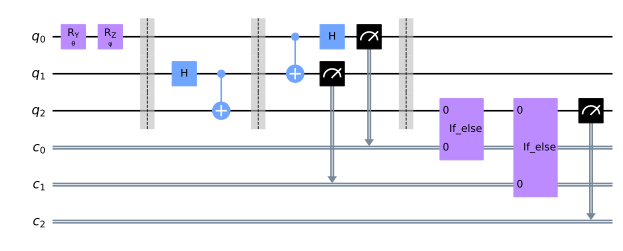

In [23]:
circ = QuantumCircuit(3, 3)
qubits, bits = circ.qregs[0], circ.cregs[0]
# 1. Parametric 1-qubit state for Alice, to be teleported
circ.ry(theta, 0)
circ.rz(phi, 0)
circ.barrier()
# 2. Prepare 2-qubit Bell state between Alice and Bob
circ.h(1)
circ.cx(1, 2)
circ.barrier()
# 3. Perform 2-qubit Bell basis measurement on Alice's side
circ.cx(0, 1)
circ.h(0)
circ.measure([0, 1], [0, 1])
circ.barrier()
# 4. Perform correction on Bob's side
with circ.if_test([bits[0], 1]):
    circ.z(2)
with circ.if_test([bits[1], 1]):
    circ.x(2)
# 5. Measure the teleported qubits in the Z basis:
circ.measure(2, 2)
circ.draw("mpl", scale=0.8)

In [29]:
circ.parameters

ParameterView([Parameter(θ), Parameter(φ)])

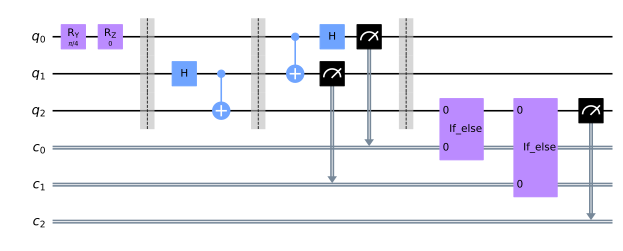

In [30]:
bound_circ = circ.assign_parameters({theta: pi/4, phi: 0})
bound_circ.draw("mpl", scale=0.8)

In [31]:
bound_circ.parameters

ParameterView([])

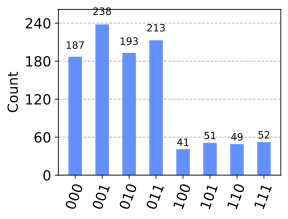

In [25]:
counts = execute(bound_circ, simulator).result().get_counts()
plot_histogram(counts, figsize=(4, 3))

**NOTE**: bits in Qiskit bitstrings are indexed right-to-left.

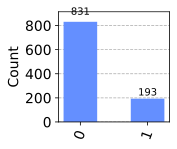

In [27]:
counts_q2 = marginal_counts(counts, [2]) # only keep counts for the measurement on q2 (value in bit 2)
plot_histogram(counts_q2, figsize=(2, 2))

A linear-depth implementation of a phase gadget (optimal is log-depth, using balanced trees).

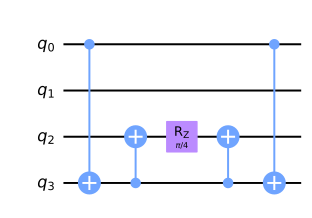

In [33]:
from collections.abc import Sequence
from typing import Union

def phase_gadget(circ: QuantumCircuit, legs: Sequence[int], angle: Union[Parameter, int, float]) -> None:
    assert len(set(legs)) == len(legs)
    cx_pairs = list(zip(legs[:-1], legs[1:]))
    # 1. Fwd ladder of CX gates
    for c, t in cx_pairs:
        circ.cx(c, t)
    # 2. Rz on last qubit
    circ.rz(angle, legs[-1])
    # 3. Bwd ladder of CX gates
    for c, t in reversed(cx_pairs):
        circ.cx(c, t)

circ = QuantumCircuit(4)
phase_gadget(circ, [0, 3, 2], pi/4)
circ.draw("mpl")

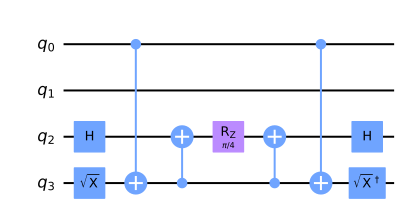

In [36]:
def basis_to_z(circ: QuantumCircuit, q: int, b: str) -> None:
    assert b in "XYZ"
    if b == "X":
        circ.h(q)
    elif b == "Y":
        circ.sx(q)

def z_to_basis(circ: QuantumCircuit, q: int, b: str) -> None:
    assert b in "XYZ"
    if b == "X":
        circ.h(q)
    elif b == "Y":
        circ.sxdg(q)

def pauli_gadget(circ: QuantumCircuit, legs: Sequence[int], basis: Sequence[str], angle: Union[Parameter, int, float]) -> None:
    # 1. Perform change of basis from leg basis to Z basis
    for q, b in zip(legs, basis):
        basis_to_z(circ, q, b)
    # 2. Apply a phase gadget (i.e. a Pauli gadget where all legs are in the Z basis)
    phase_gadget(circ, legs, angle)
    # 3. Perform change of basis from Z basis back to leg basis
    for q, b in zip(legs, basis):
        z_to_basis(circ, q, b)
    
circ = QuantumCircuit(4)
pauli_gadget(circ, [0, 3, 2], "ZYX", pi/4)
circ.draw("mpl")

Constraint $\varphi(\underline{b})$ is a function from binary variables $\underline{b}=(b_{n-1}, ..., b_1, b_0)$ to true/false. As a convention, we take "spin variables" with values $\pm 1$:

- $+1$ = false
- $-1$ = true

This way, minimising the value of a constraint is the same as satisfying the constraint.

A problem on binary variables $\underline{b}$ is just a set of constraints $\varphi_k$ to be satisfied. Define the objective/energy functions as:

$$
E(\underline{b}) = \sum_{k} \varphi_k(\underline{b})
$$

Minimising $E(\underline{b})$ is the same as maximising the number of satisfied constraints in the problem. It is also possible to add weights to the constraints:

$$
E(\underline{b}) = \sum_{k} w_k \varphi_k(\underline{b})
$$

The convention of $\pm 1$ comes from the eigenvalues of the Pauli Z observable:

$$
Z = 
\left(
\begin{array}{cc}
1 & 0\\
0 & -1
\end{array}
\right)
$$

We use the expected value of the measurement in the Z basis as a $[-1, +1]$-valued outcome:

$$
\text{ev}(\text{counts on 1 qubit}) = \mathbb{P}(0)-\mathbb{P}(1)
$$

In [39]:
circ = QuantumCircuit(1, 1)
circ.measure(0, 0)
counts = execute(circ, simulator).result().get_counts()
counts

{'0': 998, '1': 26}

In [41]:
counts_0 = counts.get("0", 0)
counts_1 = counts.get("1", 0)
shots = sum(counts.values())
ev_0 = (counts_0-counts_1)/shots
ev_0 # in [-1, +1]

0.94921875

Take $|0\rangle$ to mean "constraint violated" (exp value is +1) and $|1\rangle$ to be "constraint satisfied" (exp value is -1).

In general, "expected value" generalises to $n$-bit strings as:

$$
\mathbb{P}(\text{even bitsum})-\mathbb{P}(\text{odd bitsum})
$$

In [42]:
from collections.abc import Mapping
def expval(counts: Mapping[str, int]) -> float:
    shots = sum(counts.values())
    count_even = sum(
        bitstr_count if bitstr.count("1")%2 == 0 else 0
        for bitstr, bitstr_count in counts.items()
    )
    count_odd = shots-count_even
    return (count_even-count_odd)/shots

For 1 bit, expval is the "bias":

$$
\mathbb{P}(0)-\mathbb{P}(1)
$$

In [43]:
counts = {
    "1": 75,
    "0": 25
}
expval(counts) # closer to -1 than +1, i.e. closer to "satisfied" than "violated"

-0.5

For 2 bit, expval is the "correlation":

$$
\mathbb{P}(00)+\mathbb{P}(11)-\mathbb{P}(01)-\mathbb{P}(10)
$$

In [44]:
counts = {
    "00": 50,
    "01": 10,
    "10": 10,
    "11": 30
}
expval(counts) # closer to +1 than -1, i.e. closer to "violated" than "satisfied"

0.6

In the end, the generic constraint can be written as a linear combination of expectation values for measuremets in various subsets of qubits:

$$
\sum_{k} \varphi_k(\underline{b})
= \sum_{j} c_j O^{(j)}_1....O^{(j)}_n
$$

where $O^{(j)}_q \in \{\text{I}, \text{Z}\}$, i.e. "don't measure qubit $q$" or "measure qubit $q$ in Z basis". For example, on 2 qubits:

$$
Z_1Z_0-2Z_0+Z_1
$$

On the four computation basis states:

- $|00\rangle$ expval is $(+1)(+1)-2(+1)+(+1) = 0$
- $|01\rangle$ expval is $(-1)(+1)-2(-1)+(+1) = 2$
- $|10\rangle$ expval is $(+1)(-1)-2(+1)+(-1) = -4$ (minimum "energy" state)
- $|11\rangle$ expval is $(-1)(-1)-2(-1)+(-1) = 2$


In [48]:
def bitstr_expval(obs: Mapping[str, Union[int, float]], bitstr: str) -> float:
    n = len(bitstr)
    assert all(len(paulistr) == n for paulistr in obs.keys())
    assert all(p in "IZ" for paulistr in obs.keys() for p in paulistr)
    assert all(b in "01" for b in bitstr)
    ev = 0.0
    for paulistr, coeff in obs.items():
        s = (-1)**sum(1 if p == "Z" and b == "1" else 0 for p, b in zip(paulistr, bitstr))
        ev += s*float(coeff)
    return ev

obs = {
    "ZZ": 1,
    "IZ": -2,
    "ZI": 1
}
for bitstr in ["00", "01", "10", "11"]:
    print(bitstr, "->", bitstr_expval(obs, bitstr))

00 -> 0.0
01 -> 2.0
10 -> -4.0
11 -> 2.0


Extend from individual bitstrings to probability distributions over bitstrings (i.e. the outcome of measurement of a quantum state) by convex combination:

In [50]:
def counts_expval(obs: Mapping[str, Union[int, float]], counts: Mapping[str, float]) -> float:
    shots = sum(counts.values())
    ev = 0.0
    for bitstr, count in counts.items():
        ev += bitstr_expval(obs, bitstr)*count/shots
    return ev

obs = {
    "ZZ": 1,
    "IZ": -2,
    "ZI": 1
}
counts = {
    "00": 50,
    "01": 10,
    "10": 10,
    "11": 30
}
counts_expval(obs, counts)

0.39999999999999997

In [51]:
0.5*0+0.1*2+0.1*(-4)+0.3*2

0.39999999999999997

Goal is to turn binary/boolean constraints $\varphi(\mathbb{b})$ into functions of the bits $b_i \in \pm 1$ such that:

$$
\varphi(\mathbb{b})
= \left\{
\begin{array}{c}
+1 \text{ if the constraint is violated}\\
-1 \text{ if the constraint is satisfied}
\end{array}
\right.
$$

Identity constraint $\varphi(\underline{b}) = b_i$: satisfied (resp. violated) when variable `i` is satisfied (resp. violated).

$$
\varphi(\underline{b}) = \text{expval of measurement} \; Z_{q_i}
$$

In [ ]:
def c_bit(i: int, n: int):
    ...